In [30]:
print("ok")

ok


In [ ]:
import os
os.environ["GOOGLE_API_KEY"] = "You api key here"

In [32]:
from langchain_google_genai import ChatGoogleGenerativeAI
model= ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("Hi, how are you?")
print(output.content)

I am doing well, thank you for asking!  How are you today?


Config the embedding model

In [3]:
pip install langchain-huggingface

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install sentence-transformers

  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 553.9 kB/s eta 0:00:0000:0100:04
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl (418 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


In [33]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("Hello world!"))

384

In [34]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [35]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)

In [36]:
docs=loader.load()

In [37]:
docs

[Document(metadata={'source': '../data/usa.txt'}, page_content="🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks

In [38]:
docs[0].page_content

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

In [39]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)

In [40]:
new_docs=text_splitter.split_documents(documents=docs)

In [41]:
doc_string=[doc.page_content for doc in new_docs]

In [42]:
doc_string

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,',
 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a',
 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.',
 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.',
 'U.S. GDP – Size, Composition, and Global Share',
 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 

In [43]:
len(doc_string)

55

In [44]:
pip install chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [45]:
db=Chroma.from_documents(new_docs,embeddings)

In [46]:
retriever = db.as_retriever(search_kwargs={"k": 3})

In [47]:
retriever.invoke("industrial growth of usa")

[Document(metadata={'source': '../data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '../data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '../data/usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [48]:
import operator
from pydantic import BaseModel,Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

In [49]:
class TopicSelectionParser(BaseModel):
    topic: str = Field(description="selected topic")
    Reasoning: str = Field(description="reasoning for the topic selection")

In [50]:
from langchain.output_parsers import PydanticOutputParser

In [51]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [52]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "reasoning for the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["topic", "Reasoning"]}\n```'

In [53]:
class Agentstate(TypedDict):
    message: Annotated[Sequence[BaseMessage], operator.add]

In [54]:
Agentstate={}

In [55]:
Agentstate["message"] = []

In [56]:
Agentstate

{'message': []}

In [57]:
Agentstate["message"].append("Hi, how are you?")

In [58]:
Agentstate

{'message': ['Hi, how are you?']}

In [59]:
Agentstate["message"].append("What are you doing?")

In [60]:
Agentstate["message"].append("I hope everything is fine.")

In [61]:
Agentstate

{'message': ['Hi, how are you?',
  'What are you doing?',
  'I hope everything is fine.']}

In [62]:
Agentstate["message"][-1]

'I hope everything is fine.'

In [63]:
def function_1(state: Agentstate):
    pass

In [64]:
def function_2(state: Agentstate):
    pass

In [65]:
def function_3(state: Agentstate):
    pass

In [66]:
def router(state:Agentstate):
    pass

In [67]:
from langgraph.graph import StateGraph,END

In [69]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    message: Sequence[BaseMessage]

workflow = StateGraph(AgentState)  # Pass the class, not an instance or dict

In [71]:
workflow = StateGraph(AgentState)

In [72]:
workflow.add_node("supervisor",function_1)

In [73]:
workflow.add_node("RAG",function_2)

In [74]:
workflow.add_node("LLM",function_3)

In [75]:
workflow.set_entry_point("supervisor")

In [76]:
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
        
    }
)

In [77]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

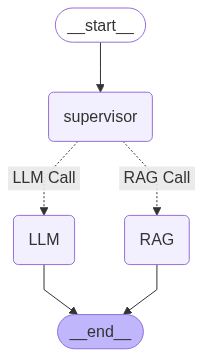

In [78]:
workflow.compile()